In [14]:
import pandas as pd

# 读取Excel文件
df = pd.read_excel('data/Served Meal Count.xlsx', usecols=['Date','Breakfast Served','Lunch Served'])

# 将Date列转换为datetime格式
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Breakfast Served,Lunch Served
0,2023-08-21,289.0,275.0
1,2023-08-22,332.0,272.0
2,2023-08-23,346.0,288.0
3,2023-08-24,366.0,292.0
4,2023-08-25,367.0,284.0
...,...,...,...
251,2024-08-16,66.0,80.0
252,2024-08-17,NaN,NaN
253,2024-08-18,NaN,NaN
254,2024-08-19,68.0,75.0


In [15]:
# 生成完整的日期范围
date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
# 索引设置为Date列
df.set_index('Date', inplace=True)
df

,Breakfast Served,Lunch Served
Date,,
2023-08-21,289.0,275.0
2023-08-22,332.0,272.0
2023-08-23,346.0,288.0
2023-08-24,366.0,292.0
2023-08-25,367.0,284.0
...,...,...
2024-08-16,66.0,80.0
2024-08-17,NaN,NaN
2024-08-18,NaN,NaN


In [16]:
# 重索引到完整的日期范围，缺失的日期行填充为NaN
df_full = df.reindex(date_range)
df_full

,Breakfast Served,Lunch Served
2023-08-21,289.0,275.0
2023-08-22,332.0,272.0
2023-08-23,346.0,288.0
2023-08-24,366.0,292.0
2023-08-25,367.0,284.0
...,...,...
2024-08-16,66.0,80.0
2024-08-17,NaN,NaN
2024-08-18,NaN,NaN
2024-08-19,68.0,75.0


In [17]:
# 对于缺失值，填充为0
df_full.fillna(0, inplace=True)
df_full

,Breakfast Served,Lunch Served
2023-08-21,289.0,275.0
2023-08-22,332.0,272.0
2023-08-23,346.0,288.0
2023-08-24,366.0,292.0
2023-08-25,367.0,284.0
...,...,...
2024-08-16,66.0,80.0
2024-08-17,0.0,0.0
2024-08-18,0.0,0.0
2024-08-19,68.0,75.0


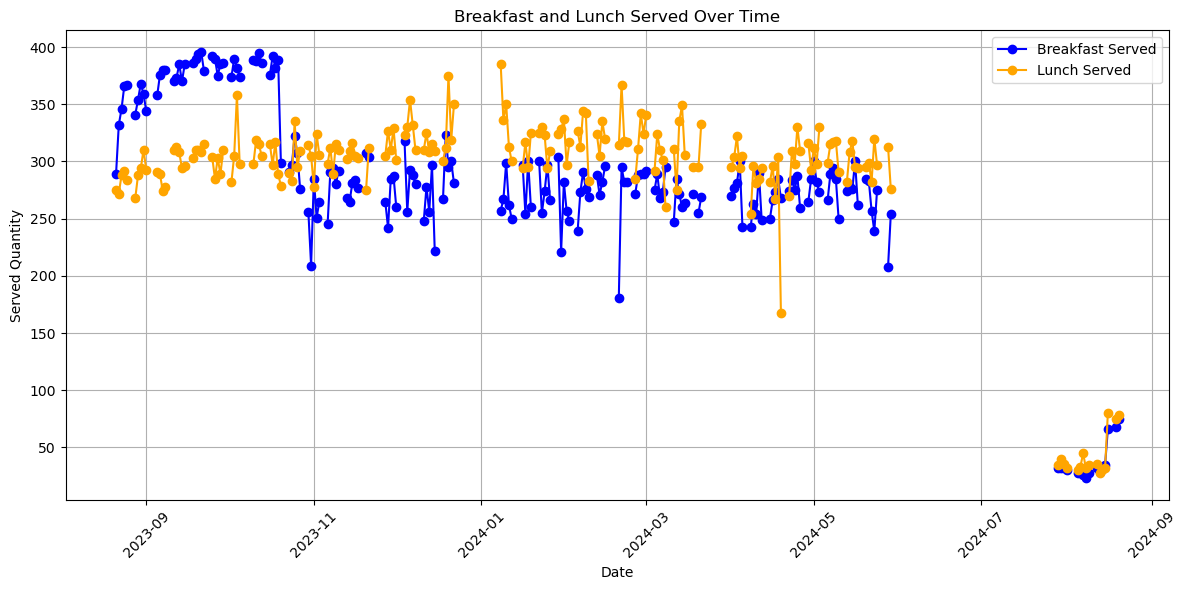

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 创建副本，替换数值为0的点为NaN
breakfast_plot = df_full['Breakfast Served'].replace(0, np.nan)
lunch_plot = df_full['Lunch Served'].replace(0, np.nan)

# 创建一个图形和坐标轴
plt.figure(figsize=(12, 6))

# 绘制 Breakfast Served 列的折线图
plt.plot(breakfast_plot, label='Breakfast Served', color='blue', marker='o')

# 绘制 Lunch Served 列的折线图
plt.plot(lunch_plot, label='Lunch Served', color='orange', marker='o')

# 添加标题和标签
plt.title('Breakfast and Lunch Served Over Time')
plt.xlabel('Date')
plt.ylabel('Served Quantity')
plt.xticks(rotation=45)  # 旋转 x 轴标签以便更好地显示
plt.legend()  # 显示图例
plt.grid()  # 添加网格

# 显示图形
plt.tight_layout()  # 调整图形以适应布局
plt.show()

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays
import matplotlib.pyplot as plt

data = df_full

# 生成假期标记（美国）
us_holidays = holidays.US()

# 定义寒暑假日期（示例日期）
winter_break = pd.date_range(start='2023-12-25', end='2024-01-05')
spring_break = pd.date_range(start='2024-03-22', end='2024-03-25')
summer_break = pd.date_range(start='2024-06-03', end='2024-08-20')

# 将寒暑假日期添加到假期标记中
for date in winter_break:
    us_holidays[date] = "Winter Break"
for date in spring_break:
    us_holidays[date] = "Spring Break"
for date in summer_break:
    us_holidays[date] = "Summer Break"

# 添加假期和周末信息
data['Is_Holiday'] = data.index.map(lambda x: 1 if x in us_holidays else 0)
data['Day_of_Week'] = data.index.dayofweek
data['Is_Weekend'] = data['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)

# 新增所属月份和当年中的第几天特征
data['Month'] = data.index.month                   # 所属月份
data['Day_of_Year'] = data.index.dayofyear          # 当年中的第几天


# 创建滞后特征
for i in range(1, 8):  # 过去7天的订餐量
    data[f'Breakfast_Lag_{i}'] = data['Breakfast Served'].shift(i)
    data[f'Lunch_Lag_{i}'] = data['Lunch Served'].shift(i)

# 填充缺失值（假设为0）
data.fillna(0, inplace=True)

# 特征选择
features = ['Is_Holiday', 'Is_Weekend', 'Day_of_Week', 'Month', 'Day_of_Year']
features += [f'Breakfast_Lag_{i}' for i in range(1, 8)]
features += [f'Lunch_Lag_{i}' for i in range(1, 8)]

# 分割数据集
X = data[features]
y_breakfast = data['Breakfast Served']
y_lunch = data['Lunch Served']

# 划分数据集并保留原始索引
X_train_breakfast, X_test_breakfast, y_train_breakfast, y_test_breakfast, train_index_breakfast, test_index_breakfast = train_test_split(
    X, y_breakfast, X.index, test_size=0.2, random_state=42
)
X_train_lunch, X_test_lunch, y_train_lunch, y_test_lunch, train_index_lunch, test_index_lunch = train_test_split(
    X, y_lunch, X.index, test_size=0.2, random_state=42
)

In [20]:
X

,Is_Holiday,Is_Weekend,Day_of_Week,Month,Day_of_Year,Breakfast_Lag_1,Breakfast_Lag_2,Breakfast_Lag_3,Breakfast_Lag_4,Breakfast_Lag_5,Breakfast_Lag_6,Breakfast_Lag_7,Lunch_Lag_1,Lunch_Lag_2,Lunch_Lag_3,Lunch_Lag_4,Lunch_Lag_5,Lunch_Lag_6,Lunch_Lag_7
2023-08-21,0,0,0,8,233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-22,0,0,1,8,234,289.0,0.0,0.0,0.0,0.0,0.0,0.0,275.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-23,0,0,2,8,235,332.0,289.0,0.0,0.0,0.0,0.0,0.0,272.0,275.0,0.0,0.0,0.0,0.0,0.0
2023-08-24,0,0,3,8,236,346.0,332.0,289.0,0.0,0.0,0.0,0.0,288.0,272.0,275.0,0.0,0.0,0.0,0.0
2023-08-25,0,0,4,8,237,366.0,346.0,332.0,289.0,0.0,0.0,0.0,292.0,288.0,272.0,275.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-16,1,0,4,8,229,35.0,33.0,29.0,32.0,0.0,0.0,28.0,32.0,30.0,28.0,36.0,0.0,0.0,35.0
2024-08-17,1,1,5,8,230,66.0,35.0,33.0,29.0,32.0,0.0,0.0,80.0,32.0,30.0,28.0,36.0,0.0,0.0
2024-08-18,1,1,6,8,231,0.0,66.0,35.0,33.0,29.0,32.0,0.0,0.0,80.0,32.0,30.0,28.0,36.0,0.0
2024-08-19,1,0,0,8,232,0.0,0.0,66.0,35.0,33.0,29.0,32.0,0.0,0.0,80.0,32.0,30.0,28.0,36.0


In [21]:
# 使用随机森林回归模型
breakfast_model = RandomForestRegressor(n_estimators=256, random_state=42)
lunch_model = RandomForestRegressor(n_estimators=256, random_state=42)

# 模型训练
breakfast_model.fit(X, y_breakfast)
lunch_model.fit(X, y_lunch)

# 模型推理
pred_train_breakfast = breakfast_model.predict(X_train_breakfast)
pred_train_lunch = lunch_model.predict(X_train_lunch)

pred_test_breakfast = breakfast_model.predict(X_test_breakfast)
pred_test_lunch = lunch_model.predict(X_test_lunch)

pred_breakfast = breakfast_model.predict(X)
pred_lunch = lunch_model.predict(X)

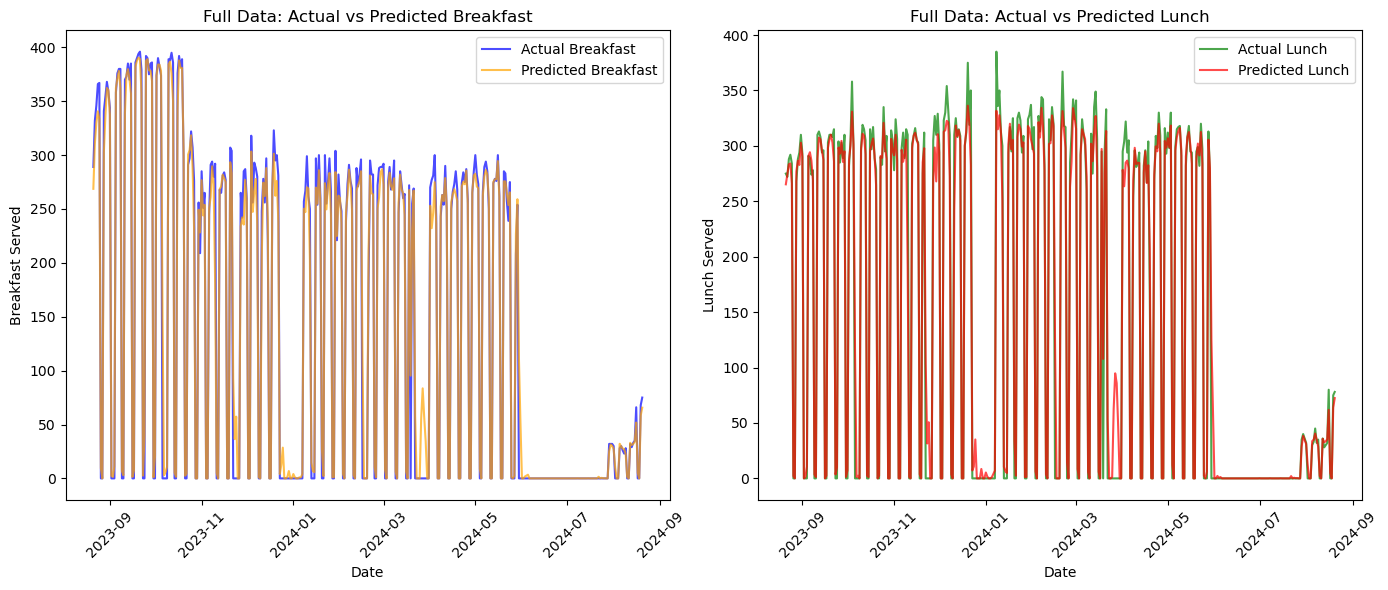

In [22]:
# 使用完整数据集进行预测

# 绘制未划分数据集的真实标签与预测标签对比
plt.figure(figsize=(14, 6))

# 早餐：完整数据集的真实值与预测值对比
plt.subplot(1, 2, 1)
plt.plot(data.index, y_breakfast, label='Actual Breakfast', color='blue', alpha=0.7)
plt.plot(data.index, pred_breakfast, label='Predicted Breakfast', color='orange', alpha=0.7)
plt.title('Full Data: Actual vs Predicted Breakfast')
plt.xlabel('Date')
plt.ylabel('Breakfast Served')
plt.legend()
plt.xticks(rotation=45)

# 午餐：完整数据集的真实值与预测值对比
plt.subplot(1, 2, 2)
plt.plot(data.index, y_lunch, label='Actual Lunch', color='green', alpha=0.7)
plt.plot(data.index, pred_lunch, label='Predicted Lunch', color='red', alpha=0.7)
plt.title('Full Data: Actual vs Predicted Lunch')
plt.xlabel('Date')
plt.ylabel('Lunch Served')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

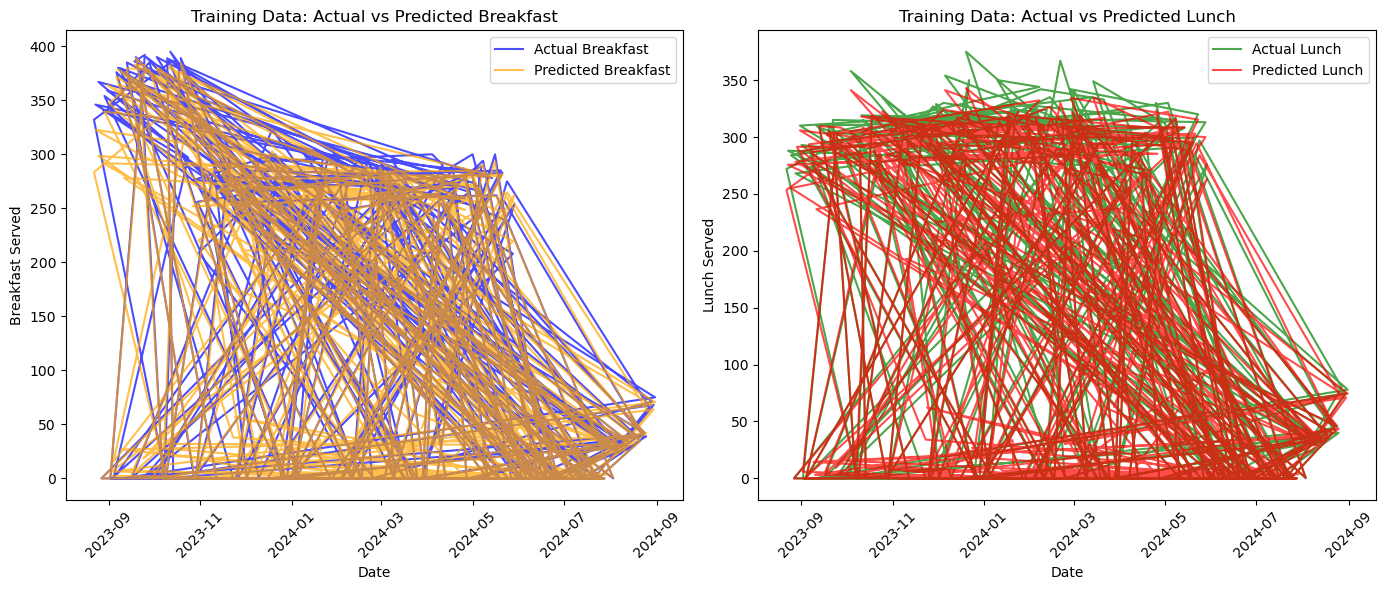

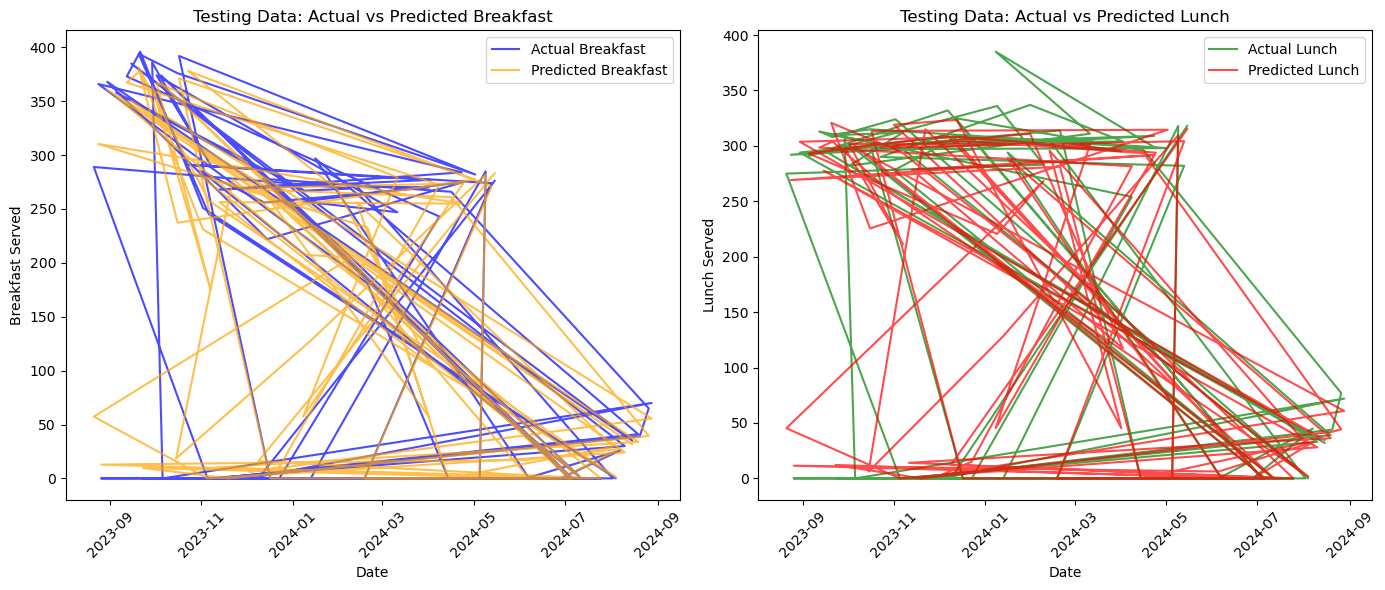

In [68]:
# 绘制训练数据的真实标签与预测标签对比
plt.figure(figsize=(14, 6))

# 早餐：训练数据真实与预测值对比
plt.subplot(1, 2, 1)
plt.plot(train_index_breakfast, y_train_breakfast, label='Actual Breakfast', color='blue', alpha=0.7)
plt.plot(train_index_breakfast,pred_train_breakfast, label='Predicted Breakfast', color='orange', alpha=0.7)
plt.title('Training Data: Actual vs Predicted Breakfast')
plt.xlabel('Date')
plt.ylabel('Breakfast Served')
plt.legend()
plt.xticks(rotation=45)

# 午餐：训练数据真实与预测值对比
plt.subplot(1, 2, 2)
plt.plot(train_index_lunch, y_train_lunch, label='Actual Lunch', color='green', alpha=0.7)
plt.plot(train_index_lunch, pred_train_lunch, label='Predicted Lunch', color='red', alpha=0.7)
plt.title('Training Data: Actual vs Predicted Lunch')
plt.xlabel('Date')
plt.ylabel('Lunch Served')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 绘制测试数据的真实标签与预测标签对比
plt.figure(figsize=(14, 6))

# 早餐：测试数据真实与预测值对比
plt.subplot(1, 2, 1)
plt.plot(test_index_breakfast, y_test_breakfast, label='Actual Breakfast', color='blue', alpha=0.7)
plt.plot(test_index_breakfast, pred_test_breakfast, label='Predicted Breakfast', color='orange', alpha=0.7)
plt.title('Testing Data: Actual vs Predicted Breakfast')
plt.xlabel('Date')
plt.ylabel('Breakfast Served')
plt.legend()
plt.xticks(rotation=45)

# 午餐：测试数据真实与预测值对比
plt.subplot(1, 2, 2)
plt.plot(test_index_lunch, y_test_lunch, label='Actual Lunch', color='green', alpha=0.7)
plt.plot(test_index_lunch, pred_test_lunch, label='Predicted Lunch', color='red', alpha=0.7)
plt.title('Testing Data: Actual vs Predicted Lunch')
plt.xlabel('Date')
plt.ylabel('Lunch Served')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Breakfast MSE: 920.6852870631863
Lunch MSE: 948.1884843980944
Breakfast MAE: 14.597550675675675
Lunch MAE: 14.45460304054054
Breakfast R² Score: 0.9607218135961537
Lunch R² Score: 0.9570514142473074


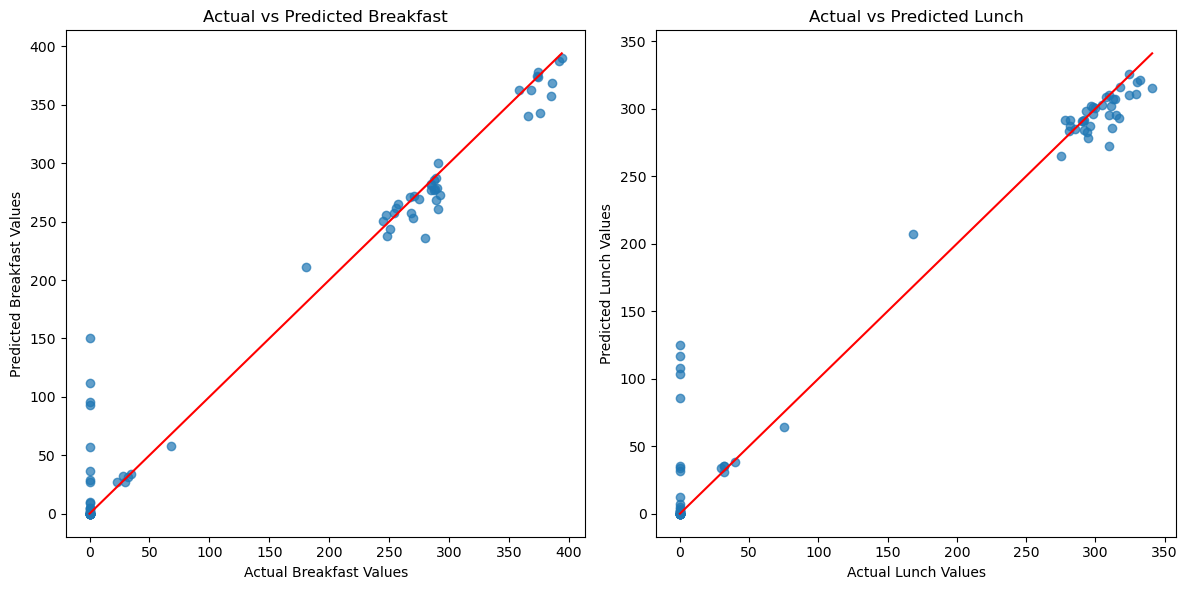

In [23]:

# 模型性能评估
breakfast_mse = mean_squared_error(y_test_breakfast, pred_test_breakfast)
lunch_mse = mean_squared_error(y_test_lunch, pred_test_lunch)
breakfast_mae = mean_absolute_error(y_test_breakfast, pred_test_breakfast)
lunch_mae = mean_absolute_error(y_test_lunch, pred_test_lunch)
breakfast_r2 = r2_score(y_test_breakfast, pred_test_breakfast)
lunch_r2 = r2_score(y_test_lunch, pred_test_lunch)

print(f'Breakfast MSE: {breakfast_mse}')
print(f'Lunch MSE: {lunch_mse}')
print(f'Breakfast MAE: {breakfast_mae}')
print(f'Lunch MAE: {lunch_mae}')
print(f'Breakfast R² Score: {breakfast_r2}')
print(f'Lunch R² Score: {lunch_r2}')

# 可视化评估
plt.figure(figsize=(12, 6))

# 散点图
plt.subplot(1, 2, 1)
plt.scatter(y_test_breakfast, pred_test_breakfast, alpha=0.7)
plt.xlabel('Actual Breakfast Values')
plt.ylabel('Predicted Breakfast Values')
plt.title('Actual vs Predicted Breakfast')
plt.plot([y_test_breakfast.min(), y_test_breakfast.max()],
         [y_test_breakfast.min(), y_test_breakfast.max()], color='red')  # 理想预测线

plt.subplot(1, 2, 2)
plt.scatter(y_test_lunch, pred_test_lunch, alpha=0.7)
plt.xlabel('Actual Lunch Values')
plt.ylabel('Predicted Lunch Values')
plt.title('Actual vs Predicted Lunch')
plt.plot([y_test_lunch.min(), y_test_lunch.max()],
         [y_test_lunch.min(), y_test_lunch.max()], color='red')  # 理想预测线

plt.tight_layout()
plt.show()

In [26]:
# 手动指定初始的七天滞后数据
initial_lags_breakfast = [254, 300, 321, 298, 341, 300, 299]
initial_lags_lunch = [270, 315, 340, 310, 350, 305, 320]
previous_days = len(initial_lags_breakfast)

# 设置预测的天数（例如7天）
prediction_days = 7
# future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=prediction_days)
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=previous_days), periods=prediction_days)
future_data = pd.DataFrame(index=future_dates)

# 初始化特征
future_data['Is_Holiday'] = future_data.index.map(lambda x: 1 if x in us_holidays else 0)
future_data['Day_of_Week'] = future_data.index.dayofweek
future_data['Is_Weekend'] = future_data['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)
future_data['Month'] = future_data.index.month
future_data['Day_of_Year'] = future_data.index.dayofyear

# 逐步预测未来几天的数据，并更新滞后特征
breakfast_predictions = []
lunch_predictions = []

for date in future_dates:
    # 创建滞后特征，使用当前的7天滞后数据
    for i in range(7):
        future_data.loc[date, f'Breakfast_Lag_{i+1}'] = initial_lags_breakfast[-(i+1)]
        future_data.loc[date, f'Lunch_Lag_{i+1}'] = initial_lags_lunch[-(i+1)]

    # 使用模型进行预测
    X_future = future_data.loc[date, features].values.reshape(1, -1)
    breakfast_pred = breakfast_model.predict(X_future)[0]
    lunch_pred = lunch_model.predict(X_future)[0]

    # 将预测值存储
    breakfast_predictions.append(breakfast_pred)
    lunch_predictions.append(lunch_pred)

    # 更新滞后特征（把当天的预测值加入滞后列表末尾，并移除最早的值）
    initial_lags_breakfast.append(breakfast_pred)
    initial_lags_lunch.append(lunch_pred)
    initial_lags_breakfast.pop(0)
    initial_lags_lunch.pop(0)

# 将预测结果添加到 future_data 中
future_data['Predicted_Breakfast'] = breakfast_predictions
future_data['Predicted_Lunch'] = lunch_predictions

# 查看未来一周的预测结果
future_data[['Predicted_Breakfast', 'Predicted_Lunch']]


D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles

,Predicted_Breakfast,Predicted_Lunch
2024-08-27,229.011719,262.210938
2024-08-28,247.652344,295.113281
2024-08-29,175.042969,186.406250
2024-08-30,294.171875,278.476562
2024-08-31,320.402344,279.792969
2024-09-01,246.468750,290.570312
2024-09-02,67.296875,70.234375


In [150]:
# 手动指定初始的七天滞后数据（可以少于7天）
initial_lags_breakfast = [254, 300, 321, 298, 341, 300, 299]
initial_lags_lunch = [270, 315, 340, 310, 350, 305, 320]

# 设置预测的天数（例如7天）
prediction_days = 7

# 确定起始日期，去掉手动指定的那几天（假设为len(initial_lags_breakfast)天）
start_date = data.index[-1] + pd.Timedelta(days=1) - pd.Timedelta(days=len(initial_lags_breakfast))

# 生成未来预测日期
future_dates = pd.date_range(start=start_date, periods=prediction_days)
future_data = pd.DataFrame(index=future_dates)

# 初始化特征
future_data['Is_Holiday'] = future_data.index.map(lambda x: 1 if x in us_holidays else 0)
future_data['Day_of_Week'] = future_data.index.dayofweek
future_data['Is_Weekend'] = future_data['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)
future_data['Month'] = future_data.index.month
future_data['Day_of_Year'] = future_data.index.dayofyear

# 逐步预测未来几天的数据，并更新滞后特征
breakfast_predictions = []
lunch_predictions = []

for date in future_dates:
    # 创建滞后特征，确保使用的滞后数据长度为7
    for i in range(7):
        if len(initial_lags_breakfast) >= (i + 1):
            future_data.loc[date, f'Breakfast_Lag_{i+1}'] = initial_lags_breakfast[-(i + 1)]
        else:
            future_data.loc[date, f'Breakfast_Lag_{i+1}'] = 0  # 如果没有数据，填充为0

        if len(initial_lags_lunch) >= (i + 1):
            future_data.loc[date, f'Lunch_Lag_{i+1}'] = initial_lags_lunch[-(i + 1)]
        else:
            future_data.loc[date, f'Lunch_Lag_{i+1}'] = 0  # 如果没有数据，填充为0

    # 使用模型进行预测
    X_future = future_data.loc[date, features].values.reshape(1, -1)
    breakfast_pred = breakfast_model.predict(X_future)[0]
    lunch_pred = lunch_model.predict(X_future)[0]

    # 将预测值存储
    breakfast_predictions.append(breakfast_pred)
    lunch_predictions.append(lunch_pred)

    # 更新滞后特征（把当天的预测值加入滞后列表末尾，并移除最早的值）
    initial_lags_breakfast.append(breakfast_pred)
    initial_lags_lunch.append(lunch_pred)

    # 确保长度保持在7个元素
    if len(initial_lags_breakfast) > 7:
        initial_lags_breakfast.pop(0)
    if len(initial_lags_lunch) > 7:
        initial_lags_lunch.pop(0)

# 将预测结果添加到 future_data 中
future_data['Predicted_Breakfast'] = breakfast_predictions
future_data['Predicted_Lunch'] = lunch_predictions

# 查看未来一周的预测结果
future_data[['Predicted_Breakfast', 'Predicted_Lunch']]


D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles

,Predicted_Breakfast,Predicted_Lunch
2024-08-14,174.226562,182.031250
2024-08-15,81.175781,79.921875
2024-08-16,47.906250,48.437500
2024-08-17,4.753906,6.054688
2024-08-18,9.039062,6.054688
2024-08-19,0.000000,0.000000
2024-08-20,0.000000,0.000000


In [151]:
# 手动指定初始的七天滞后数据（可以少于7天）
initial_lags_breakfast = [254, 300, 321, 298, 341, 300, 299]
initial_lags_lunch = [270, 315, 340, 310, 350, 305, 320]

# 获取数据的最后一天
last_date = data.index[-1]
# 计算预测的起始日期
start_prediction_date = last_date + pd.Timedelta(days=len(initial_lags_breakfast))

# 设置预测的天数（例如7天）
prediction_days = 7
future_dates = pd.date_range(start=start_prediction_date, periods=prediction_days)
future_data = pd.DataFrame(index=future_dates)

# 初始化特征
future_data['Is_Holiday'] = future_data.index.map(lambda x: 1 if x in us_holidays else 0)
future_data['Day_of_Week'] = future_data.index.dayofweek
future_data['Is_Weekend'] = future_data['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)
future_data['Month'] = future_data.index.month
future_data['Day_of_Year'] = future_data.index.dayofyear

# 逐步预测未来几天的数据，并更新滞后特征
breakfast_predictions = []
lunch_predictions = []

for date in future_dates:
    # 创建滞后特征，确保使用的滞后数据长度为7
    for i in range(7):
        if len(initial_lags_breakfast) >= (i + 1):
            future_data.loc[date, f'Breakfast_Lag_{i+1}'] = initial_lags_breakfast[-(i + 1)]
        else:
            future_data.loc[date, f'Breakfast_Lag_{i+1}'] = 0  # 如果没有数据，填充为0

        if len(initial_lags_lunch) >= (i + 1):
            future_data.loc[date, f'Lunch_Lag_{i+1}'] = initial_lags_lunch[-(i + 1)]
        else:
            future_data.loc[date, f'Lunch_Lag_{i+1}'] = 0  # 如果没有数据，填充为0

    # 使用模型进行预测
    X_future = future_data.loc[date, features].values.reshape(1, -1)
    breakfast_pred = breakfast_model.predict(X_future)[0]
    lunch_pred = lunch_model.predict(X_future)[0]

    # 将预测值存储
    breakfast_predictions.append(breakfast_pred)
    lunch_predictions.append(lunch_pred)

    # 更新滞后特征（把当天的预测值加入滞后列表末尾，并移除最早的值）
    initial_lags_breakfast.append(breakfast_pred)
    initial_lags_lunch.append(lunch_pred)

    # 确保长度保持在7个元素
    if len(initial_lags_breakfast) > 7:
        initial_lags_breakfast.pop(0)
    if len(initial_lags_lunch) > 7:
        initial_lags_lunch.pop(0)

# 将预测结果添加到 future_data 中
future_data['Predicted_Breakfast'] = breakfast_predictions
future_data['Predicted_Lunch'] = lunch_predictions

# 查看未来一周的预测结果
future_data[['Predicted_Breakfast', 'Predicted_Lunch']]


D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles

,Predicted_Breakfast,Predicted_Lunch
2024-08-27,227.324219,266.199219
2024-08-28,241.667969,295.250000
2024-08-29,170.617188,191.378906
2024-08-30,292.304688,282.847656
2024-08-31,323.152344,281.847656
2024-09-01,247.167969,300.046875
2024-09-02,67.296875,70.234375
